In [1]:
rm(list=ls())
gc()
setwd("/hpc/group/pbenfeylab/CheWei")

used    (Mb) gc trigger (Mb) max used (Mb)
Ncells  622327 33.3 1354440    72.4 1315865  70.3
Vcells 1154151  8.9 8388608    64.0 1802274  13.8

In [2]:
as.numeric(system("awk '/MemFree/ {print $2}' /proc/meminfo", intern=TRUE))

[1] 595754588

In [3]:
suppressMessages(library(Matrix))
suppressMessages(library(ggplot2))
suppressMessages(library(scales))
suppressMessages(library(rjson))
suppressMessages(library(R2HTML))
suppressMessages(library(Seurat))
#suppressMessages(library(DoubletFinder))
suppressMessages(library(plotly))
suppressMessages(library(future))
suppressMessages(library(grid))
suppressMessages(library(tidyverse))

In [4]:
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Stream 8

Matrix products: default
BLAS/LAPACK: /hpc/group/pbenfeylab/tmn23/miniconda3/envs/seu3/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] forcats_0.5.2   stringr_1.5.0   dplyr_1.0.10    purrr_1.0.1    
 [5] readr_2.1.3     tidyr_1.3.0     tibble_3.1.8    tidyverse_1.3.2
 [9] future_1.30.0   plotly_4.10.1   Seurat_3.1.5    R2HTML_2.3.3   
[13] rjson_0.2.21    scales_1.2.1    ggplot2_3.4.0   Matrix_1.5-3   

loa

In [5]:
cc.genes <- as.character(read.table("./COPILOT_other_projects/cell_cycle_genes.csv", header=F)$V1)
pp.genes <- as.character(read.table("./COPILOT_other_projects/Protoplasting_DEgene_FC2_list.txt", header=F)$V1)
id2name <- read.table("./COPILOT_other_projects/ID2Name.txt", header=F)
#source("./COPILOT_functions.R")
#source("./multi_component_RGE.r")
load("./COPILOT_other_projects/color_scheme_at.RData")

In [6]:

use.sample <- c("sc_12","dc1", "dc2", "briT", "briTR","sc_130", "sc_131", "sc_132", "sc_134", "sc_135", "sc_136") 

use.sample

[1] "sc_12"  "dc1"    "dc2"    "briT"   "briTR"  "sc_130" "sc_131" "sc_132"
 [9] "sc_134" "sc_135" "sc_136"

In [7]:
(list.filenames <- list.files(path = "./scRNA-seq/Seurat_Objects/",pattern=".rds$") %>% .[match(use.sample, gsub("_COPILOT.rds","",.))])

[1] "sc_12_COPILOT.rds"  "dc1_COPILOT.rds"    "dc2_COPILOT.rds"   
 [4] "briT_COPILOT.rds"   "briTR_COPILOT.rds"  "sc_130_COPILOT.rds"
 [7] "sc_131_COPILOT.rds" "sc_132_COPILOT.rds" "sc_134_COPILOT.rds"
[10] "sc_135_COPILOT.rds" "sc_136_COPILOT.rds"

In [8]:
read_seu <- function(dir,sample.name) { 
  #bscs <- read.csv("../../proj_sc/cbpsc/Benfey_single_cell-Samples.csv", na.strings=c("","NA"))
  #bscs <- bscs %>% select(c('sample','name','source','genotype','transgene','treatment','age','timepoint','rep','target_cells','date','seq_run')) %>% filter(sample==sample.name)
  #bscs$date <- gsub('^([0-9]{4})([0-9]{2})([0-9]+)$', '\\1-\\2-\\3', bscs$date)
  #bscs$target_cells <- prettyNum(bscs$target_cells, big.mark = ',')
  #bscs <- t(bscs)
  
  seu <- readRDS(dir) 
  #seu@misc$sample.meta.data <- list(bscs)
  seu@assays$spliced_RNA <- NULL
  seu@assays$spliced_SCT <- NULL
  seu@assays$unspliced_RNA <- NULL
  seu@assays$unspliced_SCT <- NULL
  return(seu)
}

list.filenames <- list.files(path = "./scRNA-seq/Seurat_Objects/",pattern=".rds$") %>% .[match(use.sample, gsub("_COPILOT.rds","",.))]

rc.list <- list()

for (i in 1:length(list.filenames))
{
  rc.list[[i]]<-read_seu(dir = paste0("./scRNA-seq/Seurat_Objects/",list.filenames[i]), sample.name = use.sample[i])
}

names(rc.list) <- list.filenames %>% gsub("_COPILOT.rds","",.)

for (i in 1:length(list.filenames))
{
  rc.list[[i]]<- suppressWarnings(suppressMessages(UpdateSeuratObject(rc.list[[i]])))
}

In [9]:
# Transfer labels
#meta <- c()
#for (i in 1:length(rc.list)){
#    meta <- bind_rows(meta,rc.list[[i]]@meta.data)
#}

In [10]:
#rc.integrated <- readRDS("./Integration/rc.integrated_11S_bri1_seu3_20211021.rds")

In [11]:
#rc.integrated@meta.data <- meta

In [12]:
rc.features <- SelectIntegrationFeatures(object.list = rc.list, nfeatures = 25000)
length(rc.features)

[1] 20010

In [13]:
rc.features <- rc.features[-c(grep("ATMG",rc.features),grep("ATCG",rc.features),sort(match(pp.genes, rc.features)))]
length(rc.features)

[1] 17520

In [14]:
rc.list

$sc_12
An object of class Seurat 
49648 features across 10293 samples within 2 assays 
Active assay: SCT (23357 features, 23357 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

$dc1
An object of class Seurat 
47748 features across 3378 samples within 2 assays 
Active assay: SCT (21818 features, 21818 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

$dc2
An object of class Seurat 
47752 features across 3283 samples within 2 assays 
Active assay: SCT (22007 features, 22007 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

$briT
An object of class Seurat 
51399 features across 7483 samples within 2 assays 
Active assay: SCT (24373 features, 24373 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

$briTR
An object of class Seurat 
51367 features across 8318 samples within 2 assays 
Active assay: SCT (24290 f

In [15]:
rc.list <- PrepSCTIntegration(object.list = rc.list, anchor.features = rc.features, verbose = TRUE)

In [16]:
# Use sc_12 as reference
rc.anchors <- suppressMessages(FindIntegrationAnchors(object.list = rc.list, normalization.method = "SCT", 
    anchor.features = rc.features, verbose = TRUE, reference=1))

Warning message in CheckDuplicateCellNames(object.list = object.list):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”


In [17]:
rc.integrated <- suppressMessages(IntegrateData(anchorset = rc.anchors, normalization.method = "SCT", verbose = TRUE))

Warning message:
“Adding a command log without an assay associated with it”


In [18]:
rc.integrated <- RunPCA(rc.integrated, npcs = 50, verbose = FALSE, approx = FALSE)

In [19]:
rc.integrated <- RunUMAP(rc.integrated, reduction = "pca", dims = 1:50, umap.method = "umap-learn", metric = "correlation", n.components = 3)
rc.integrated@reductions$umap_3D <- rc.integrated@reductions$umap
rc.integrated <- RunUMAP(rc.integrated, reduction = "pca", dims = 1:50, umap.method = "umap-learn", metric = "correlation")
rc.integrated@reductions$umap_2D <- rc.integrated@reductions$umap
rc.integrated <- FindNeighbors(rc.integrated, reduction = "pca",dims = 1:50)
rc.integrated <- FindClusters(rc.integrated, resolution = 5, algorithm = 3)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 72381
Number of edges: 2224094

Running smart local moving algorithm...
Maximum modularity in 10 random starts: 0.8669
Number of communities: 107
Elapsed time: 76 seconds


In [20]:
afm <- as.matrix(rc.integrated@assays$integrated@data)
pooled <- matrix(nrow=nrow(afm), ncol = 0)
for (i in 0:(length(unique(rc.integrated@meta.data$seurat_clusters))-1)) {
m <- afm[,which(rc.integrated@meta.data$seurat_clusters==i)]
pooled <- cbind(pooled, rowSums(m)/ncol(m))
}

In [21]:
    load(file="./COPILOT_other_projects/Root_bulk_arabidopsis_curated.RD")    
    time <- Reduce(merge.rownames, list(time,pooled))
    celltype <- Reduce(merge.rownames, list(celltype,pooled)) 
  
    time_label=c("Elongation", "Maturation", "Meristem")
    celltype_label=c("phloem & companion cells", "developing cortex", "hair cells", "matured cortex",
                     "matured endodermis", "non-hair cells", "columella", "phloem pole pericycle", 
                     "matured xylem pole", "protophloem & metaphloem","developing xylem", "endodermis & QC cells", "LRC & non-hair cells","QC cells")
    
    time_stat <- suppressWarnings(sapply(4:ncol(time), function(i) sapply(1:3, function(j) cor.test(time[,i],time[,j],method = "spearman")[c(3,4)])))
    time_cor <- time_stat[seq(2,nrow(time_stat),2),]
    time_pvalue <- time_stat[seq(1,nrow(time_stat)-1,2),]                                                                                                        
    time_max <- sapply(1:(ncol(time)-3), function(i) max(as.numeric(time_cor[,i])))
    time_ident <- sapply(1:(ncol(time)-3), function(i) time_label[which(as.numeric(time_cor[,i])==max(as.numeric(time_cor[,i])))])
    time_maxp <- sapply(1:(ncol(time)-3), function(i) as.numeric(time_pvalue[,i])[which(as.numeric(time_cor[,i])==max(as.numeric(time_cor[,i])))])                     
    names(time_max) <- time_ident

    celltype_stat <- suppressWarnings(sapply(15:ncol(celltype), function(i) sapply(1:14, function(j) cor.test(celltype[,i],celltype[,j],method = "spearman")[c(3,4)])))
    celltype_cor <- celltype_stat[seq(2,nrow(celltype_stat),2),]
    celltype_pvalue <- celltype_stat[seq(1,nrow(celltype_stat)-1,2),]                        
    celltype_max <- sapply(1:(ncol(celltype)-14), function(i) max(as.numeric(celltype_cor[,i])))
    celltype_ident <- sapply(1:(ncol(celltype)-14), function(i) celltype_label[which(as.numeric(celltype_cor[,i])==max(as.numeric(celltype_cor[,i])))])
    celltype_maxp <- sapply(1:(ncol(celltype)-14), function(i) as.numeric(celltype_pvalue[,i])[which(as.numeric(celltype_cor[,i])==max(as.numeric(celltype_cor[,i])))])   
    names(celltype_max) <- celltype_ident

    seucluster.celltype.ID <- celltype_ident
    seucluster.timezone.ID <- time_ident
    seucluster.celltype.cor <- celltype_max
    seucluster.timezone.cor <- time_max
    seucluster.celltype.pvalue <- celltype_maxp
    seucluster.timezone.pvalue <- time_maxp

    time_stat <- suppressWarnings(sapply(4:ncol(time), function(i) sapply(1:3, function(j) cor.test(time[,i],time[,j],method = "pearson")[c(3,4)])))
    time_cor <- time_stat[seq(2,nrow(time_stat),2),]
    time_pvalue <- time_stat[seq(1,nrow(time_stat)-1,2),]                                                                                                        
    time_max <- sapply(1:(ncol(time)-3), function(i) max(as.numeric(time_cor[,i])))
    time_ident <- sapply(1:(ncol(time)-3), function(i) time_label[which(as.numeric(time_cor[,i])==max(as.numeric(time_cor[,i])))])
    time_maxp <- sapply(1:(ncol(time)-3), function(i) as.numeric(time_pvalue[,i])[which(as.numeric(time_cor[,i])==max(as.numeric(time_cor[,i])))])                     
    names(time_max) <- time_ident

    celltype_stat <- suppressWarnings(sapply(15:ncol(celltype), function(i) sapply(1:14, function(j) cor.test(celltype[,i],celltype[,j],method = "pearson")[c(3,4)])))
    celltype_cor <- celltype_stat[seq(2,nrow(celltype_stat),2),]
    celltype_pvalue <- celltype_stat[seq(1,nrow(celltype_stat)-1,2),]                        
    celltype_max <- sapply(1:(ncol(celltype)-14), function(i) max(as.numeric(celltype_cor[,i])))
    celltype_ident <- sapply(1:(ncol(celltype)-14), function(i) celltype_label[which(as.numeric(celltype_cor[,i])==max(as.numeric(celltype_cor[,i])))])
    celltype_maxp <- sapply(1:(ncol(celltype)-14), function(i) as.numeric(celltype_pvalue[,i])[which(as.numeric(celltype_cor[,i])==max(as.numeric(celltype_cor[,i])))])   
    names(celltype_max) <- celltype_ident

    seucluster.celltype.ID.P <- celltype_ident
    seucluster.timezone.ID.P <- time_ident
    seucluster.celltype.cor.P <- celltype_max
    seucluster.timezone.cor.P <- time_max
    seucluster.celltype.pvalue.P <- celltype_maxp
    seucluster.timezone.pvalue.P <- time_maxp
                
    time <- Reduce(merge.rownames, list(Long,pooled))
    celltype <- Reduce(merge.rownames, list(Rad,pooled)) 
                             
    time_label=c("Columella", "Meri-1", "Meri-2", "Meri-3", "Meri-4", "Meri-5", "Meri-6", "Elong-7", "Elong-8", "Mat-9", "Mat-10", "Mat-11", "Mat-12")
    celltype_label=c("QC", "Hair Cell", "Cortex", "Non-Hair Cell", "Xylem Pole Pericycle", "LRC", 
                 "Columella", "Phloem Pole Pericycle", "Mat.Xylem", "Meri.Xylem", "Phloem [S32]", "Endodermis", "Phloem [SUC2]")

    time_stat <- suppressWarnings(sapply(14:ncol(time), function(i) sapply(1:13, function(j) cor.test(time[,i],time[,j],method = "spearman")[c(3,4)])))
    time_cor <- time_stat[seq(2,nrow(time_stat),2),]
    time_pvalue <- time_stat[seq(1,nrow(time_stat)-1,2),]                                                                                                        
    time_max <- sapply(1:(ncol(time)-13), function(i) max(as.numeric(time_cor[,i])))
    time_ident <- sapply(1:(ncol(time)-13), function(i) time_label[which(as.numeric(time_cor[,i])==max(as.numeric(time_cor[,i])))])
    time_maxp <- sapply(1:(ncol(time)-13), function(i) as.numeric(time_pvalue[,i])[which(as.numeric(time_cor[,i])==max(as.numeric(time_cor[,i])))])                     
    names(time_max) <- time_ident

    celltype_stat <- suppressWarnings(sapply(14:ncol(celltype), function(i) sapply(1:13, function(j) cor.test(celltype[,i],celltype[,j],method = "spearman")[c(3,4)])))
    celltype_cor <- celltype_stat[seq(2,nrow(celltype_stat),2),]
    celltype_pvalue <- celltype_stat[seq(1,nrow(celltype_stat)-1,2),]                        
    celltype_max <- sapply(1:(ncol(celltype)-13), function(i) max(as.numeric(celltype_cor[,i])))
    celltype_ident <- sapply(1:(ncol(celltype)-13), function(i) celltype_label[which(as.numeric(celltype_cor[,i])==max(as.numeric(celltype_cor[,i])))])
    celltype_maxp <- sapply(1:(ncol(celltype)-13), function(i) as.numeric(celltype_pvalue[,i])[which(as.numeric(celltype_cor[,i])==max(as.numeric(celltype_cor[,i])))])   
    names(celltype_max) <- celltype_ident

    seucluster.Rad.ID <- celltype_ident
    seucluster.Long.ID <- time_ident
    seucluster.Rad.cor <- celltype_max
    seucluster.Long.cor <- time_max
    seucluster.Rad.pvalue <- celltype_maxp
    seucluster.Long.pvalue <- time_maxp
                             
    time_stat <- suppressWarnings(sapply(14:ncol(time), function(i) sapply(1:13, function(j) cor.test(time[,i],time[,j],method = "pearson")[c(3,4)])))
    time_cor <- time_stat[seq(2,nrow(time_stat),2),]
    time_pvalue <- time_stat[seq(1,nrow(time_stat)-1,2),]                                                                                                        
    time_max <- sapply(1:(ncol(time)-13), function(i) max(as.numeric(time_cor[,i])))
    time_ident <- sapply(1:(ncol(time)-13), function(i) time_label[which(as.numeric(time_cor[,i])==max(as.numeric(time_cor[,i])))])
    time_maxp <- sapply(1:(ncol(time)-13), function(i) as.numeric(time_pvalue[,i])[which(as.numeric(time_cor[,i])==max(as.numeric(time_cor[,i])))])                     
    names(time_max) <- time_ident

    celltype_stat <- suppressWarnings(sapply(14:ncol(celltype), function(i) sapply(1:13, function(j) cor.test(celltype[,i],celltype[,j],method = "pearson")[c(3,4)])))
    celltype_cor <- celltype_stat[seq(2,nrow(celltype_stat),2),]
    celltype_pvalue <- celltype_stat[seq(1,nrow(celltype_stat)-1,2),]                        
    celltype_max <- sapply(1:(ncol(celltype)-13), function(i) max(as.numeric(celltype_cor[,i])))
    celltype_ident <- sapply(1:(ncol(celltype)-13), function(i) celltype_label[which(as.numeric(celltype_cor[,i])==max(as.numeric(celltype_cor[,i])))])
    celltype_maxp <- sapply(1:(ncol(celltype)-13), function(i) as.numeric(celltype_pvalue[,i])[which(as.numeric(celltype_cor[,i])==max(as.numeric(celltype_cor[,i])))])   
    names(celltype_max) <- celltype_ident

    seucluster.Rad.ID.P <- celltype_ident
    seucluster.Long.ID.P <- time_ident
    seucluster.Rad.cor.P <- celltype_max
    seucluster.Long.cor.P <- time_max
    seucluster.Rad.pvalue.P <- celltype_maxp
    seucluster.Long.pvalue.P <- time_maxp
      
    #store values
    rc.ori.ident <- rc.integrated@active.ident

    rc.integrated@active.ident <- rc.ori.ident
    new.cluster.ids <- seucluster.celltype.cor
    names(new.cluster.ids) <- levels(rc.integrated)
    rc.integrated <- RenameIdents(object = rc.integrated, new.cluster.ids)
    rc.integrated@meta.data$seucluster.celltype.cor <- as.numeric(levels(rc.integrated@active.ident)[rc.integrated@active.ident])
    rc.integrated@active.ident <- rc.ori.ident
    new.cluster.ids <- seucluster.celltype.pvalue
    names(new.cluster.ids) <- levels(rc.integrated)
    rc.integrated <- RenameIdents(object = rc.integrated, new.cluster.ids)
    rc.integrated@meta.data$seucluster.celltype.pvalue <- as.numeric(levels(rc.integrated@active.ident)[rc.integrated@active.ident])
    rc.integrated@active.ident <- rc.ori.ident
    new.cluster.ids <- seucluster.celltype.ID
    names(new.cluster.ids) <- levels(rc.integrated)
    rc.integrated <- RenameIdents(object = rc.integrated, new.cluster.ids)
    rc.integrated@meta.data$seucluster.celltype.ID <- as.character(rc.integrated@active.ident)

                             
    rc.integrated@active.ident <- rc.ori.ident
    new.cluster.ids <- seucluster.celltype.cor.P
    names(new.cluster.ids) <- levels(rc.integrated)
    rc.integrated <- RenameIdents(object = rc.integrated, new.cluster.ids)
    rc.integrated@meta.data$seucluster.celltype.cor.P <- as.numeric(levels(rc.integrated@active.ident)[rc.integrated@active.ident])
    rc.integrated@active.ident <- rc.ori.ident
    new.cluster.ids <- seucluster.celltype.pvalue.P
    names(new.cluster.ids) <- levels(rc.integrated)
    rc.integrated <- RenameIdents(object = rc.integrated, new.cluster.ids)
    rc.integrated@meta.data$seucluster.celltype.pvalue.P <- as.numeric(levels(rc.integrated@active.ident)[rc.integrated@active.ident])
    rc.integrated@active.ident <- rc.ori.ident
    new.cluster.ids <- seucluster.celltype.ID.P
    names(new.cluster.ids) <- levels(rc.integrated)
    rc.integrated <- RenameIdents(object = rc.integrated, new.cluster.ids)
    rc.integrated@meta.data$seucluster.celltype.ID.P <- as.character(rc.integrated@active.ident)

    rc.integrated@active.ident <- rc.ori.ident
    new.cluster.ids <- seucluster.timezone.cor
    names(new.cluster.ids) <- levels(rc.integrated)
    rc.integrated <- RenameIdents(object = rc.integrated, new.cluster.ids)
    rc.integrated@meta.data$seucluster.timezone.cor <- as.numeric(levels(rc.integrated@active.ident)[rc.integrated@active.ident])
    rc.integrated@active.ident <- rc.ori.ident
    new.cluster.ids <- seucluster.timezone.pvalue
    names(new.cluster.ids) <- levels(rc.integrated)
    rc.integrated <- RenameIdents(object = rc.integrated, new.cluster.ids)
    rc.integrated@meta.data$seucluster.timezone.pvalue <- as.numeric(levels(rc.integrated@active.ident)[rc.integrated@active.ident])
    rc.integrated@active.ident <- rc.ori.ident
    new.cluster.ids <- seucluster.timezone.ID
    names(new.cluster.ids) <- levels(rc.integrated)
    rc.integrated <- RenameIdents(object = rc.integrated, new.cluster.ids)
    rc.integrated@meta.data$seucluster.timezone.ID <- as.character(rc.integrated@active.ident)
                             
    rc.integrated@active.ident <- rc.ori.ident
    new.cluster.ids <- seucluster.timezone.cor.P
    names(new.cluster.ids) <- levels(rc.integrated)
    rc.integrated <- RenameIdents(object = rc.integrated, new.cluster.ids)
    rc.integrated@meta.data$seucluster.timezone.cor.P <- as.numeric(levels(rc.integrated@active.ident)[rc.integrated@active.ident])
    rc.integrated@active.ident <- rc.ori.ident
    new.cluster.ids <- seucluster.timezone.pvalue.P
    names(new.cluster.ids) <- levels(rc.integrated)
    rc.integrated <- RenameIdents(object = rc.integrated, new.cluster.ids)
    rc.integrated@meta.data$seucluster.timezone.pvalue.P <- as.numeric(levels(rc.integrated@active.ident)[rc.integrated@active.ident])
    rc.integrated@active.ident <- rc.ori.ident
    new.cluster.ids <- seucluster.timezone.ID.P
    names(new.cluster.ids) <- levels(rc.integrated)
    rc.integrated <- RenameIdents(object = rc.integrated, new.cluster.ids)
    rc.integrated@meta.data$seucluster.timezone.ID.P <- as.character(rc.integrated@active.ident)
    
    rc.integrated@active.ident <- rc.ori.ident
    new.cluster.ids <- seucluster.Rad.cor
    names(new.cluster.ids) <- levels(rc.integrated)
    rc.integrated <- RenameIdents(object = rc.integrated, new.cluster.ids)
    rc.integrated@meta.data$seucluster.Rad.cor <- as.numeric(levels(rc.integrated@active.ident)[rc.integrated@active.ident])
    rc.integrated@active.ident <- rc.ori.ident
    new.cluster.ids <- seucluster.Rad.pvalue
    names(new.cluster.ids) <- levels(rc.integrated)
    rc.integrated <- RenameIdents(object = rc.integrated, new.cluster.ids)
    rc.integrated@meta.data$seucluster.Rad.pvalue <- as.numeric(levels(rc.integrated@active.ident)[rc.integrated@active.ident])
    rc.integrated@active.ident <- rc.ori.ident
    new.cluster.ids <- seucluster.Rad.ID
    names(new.cluster.ids) <- levels(rc.integrated)
    rc.integrated <- RenameIdents(object = rc.integrated, new.cluster.ids)
    rc.integrated@meta.data$seucluster.Rad.ID <- as.character(rc.integrated@active.ident)
                             
    rc.integrated@active.ident <- rc.ori.ident
    new.cluster.ids <- seucluster.Rad.cor.P
    names(new.cluster.ids) <- levels(rc.integrated)
    rc.integrated <- RenameIdents(object = rc.integrated, new.cluster.ids)
    rc.integrated@meta.data$seucluster.Rad.cor.P <- as.numeric(levels(rc.integrated@active.ident)[rc.integrated@active.ident])
    rc.integrated@active.ident <- rc.ori.ident
    new.cluster.ids <- seucluster.Rad.pvalue.P
    names(new.cluster.ids) <- levels(rc.integrated)
    rc.integrated <- RenameIdents(object = rc.integrated, new.cluster.ids)
    rc.integrated@meta.data$seucluster.Rad.pvalue.P <- as.numeric(levels(rc.integrated@active.ident)[rc.integrated@active.ident])
    rc.integrated@active.ident <- rc.ori.ident
    new.cluster.ids <- seucluster.Rad.ID.P
    names(new.cluster.ids) <- levels(rc.integrated)
    rc.integrated <- RenameIdents(object = rc.integrated, new.cluster.ids)
    rc.integrated@meta.data$seucluster.Rad.ID.P <- as.character(rc.integrated@active.ident)
                             
    rc.integrated@active.ident <- rc.ori.ident
    new.cluster.ids <- seucluster.Long.cor
    names(new.cluster.ids) <- levels(rc.integrated)
    rc.integrated <- RenameIdents(object = rc.integrated, new.cluster.ids)
    rc.integrated@meta.data$seucluster.Long.cor <- as.numeric(levels(rc.integrated@active.ident)[rc.integrated@active.ident])
    rc.integrated@active.ident <- rc.ori.ident
    new.cluster.ids <- seucluster.Long.pvalue
    names(new.cluster.ids) <- levels(rc.integrated)
    rc.integrated <- RenameIdents(object = rc.integrated, new.cluster.ids)
    rc.integrated@meta.data$seucluster.Long.pvalue <- as.numeric(levels(rc.integrated@active.ident)[rc.integrated@active.ident])
    rc.integrated@active.ident <- rc.ori.ident
    new.cluster.ids <- seucluster.Long.ID
    names(new.cluster.ids) <- levels(rc.integrated)
    rc.integrated <- RenameIdents(object = rc.integrated, new.cluster.ids)
    rc.integrated@meta.data$seucluster.Long.ID <- as.character(rc.integrated@active.ident)
                             
    rc.integrated@active.ident <- rc.ori.ident
    new.cluster.ids <- seucluster.Long.cor.P
    names(new.cluster.ids) <- levels(rc.integrated)
    rc.integrated <- RenameIdents(object = rc.integrated, new.cluster.ids)
    rc.integrated@meta.data$seucluster.Long.cor.P <- as.numeric(levels(rc.integrated@active.ident)[rc.integrated@active.ident])
    rc.integrated@active.ident <- rc.ori.ident
    new.cluster.ids <- seucluster.Long.pvalue.P
    names(new.cluster.ids) <- levels(rc.integrated)
    rc.integrated <- RenameIdents(object = rc.integrated, new.cluster.ids)
    rc.integrated@meta.data$seucluster.Long.pvalue.P <- as.numeric(levels(rc.integrated@active.ident)[rc.integrated@active.ident])
    rc.integrated@active.ident <- rc.ori.ident
    new.cluster.ids <- seucluster.Long.ID.P
    names(new.cluster.ids) <- levels(rc.integrated)
    rc.integrated <- RenameIdents(object = rc.integrated, new.cluster.ids)
    rc.integrated@meta.data$seucluster.Long.ID.P <- as.character(rc.integrated@active.ident)
    

In [22]:
DF <- c()
for (i in grep("DF.classifications",colnames(rc.integrated@meta.data))){
    DF <- c(DF, rc.integrated@meta.data[,i][!is.na(rc.integrated@meta.data[,i])])
}
rc.integrated@meta.data$DF.classifications <- DF

In [39]:
#rc.integrated[["umap"]]@cell.embeddings[,1] <- rc.integrated[["umap"]]@cell.embeddings[,1]*-1
rc.integrated[["umap"]]@cell.embeddings[,2] <- rc.integrated[["umap"]]@cell.embeddings[,2]*-1
u2 <- rc.integrated@reductions$umap@cell.embeddings[,1]
u1 <- rc.integrated@reductions$umap@cell.embeddings[,2]
rc.integrated@reductions$umap@cell.embeddings[,1] <- u1
rc.integrated@reductions$umap@cell.embeddings[,2] <- u2

In [40]:
rc.integrated@reductions$umap_2D <- rc.integrated@reductions$umap 

In [41]:
options(repr.plot.width=8, repr.plot.height=8)

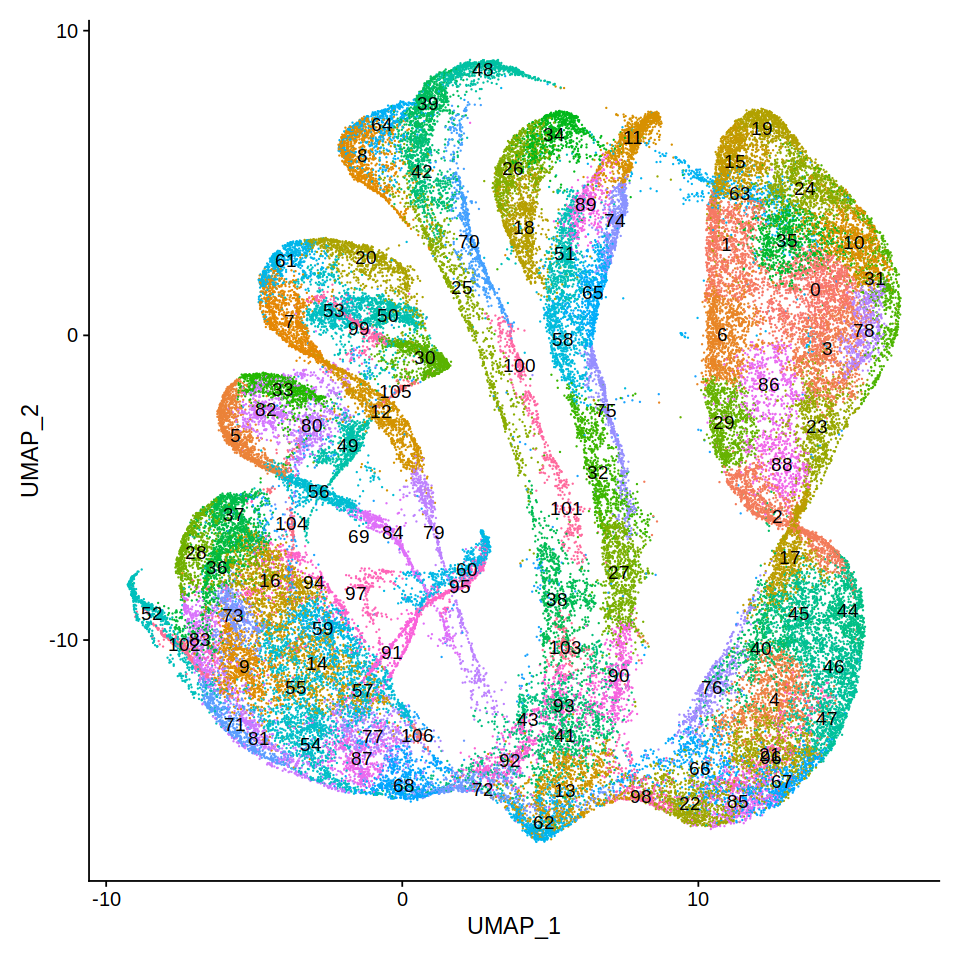

In [42]:
DimPlot(rc.integrated, reduction = "umap", group.by = "seurat_clusters", label = TRUE)+theme(legend.position="none")

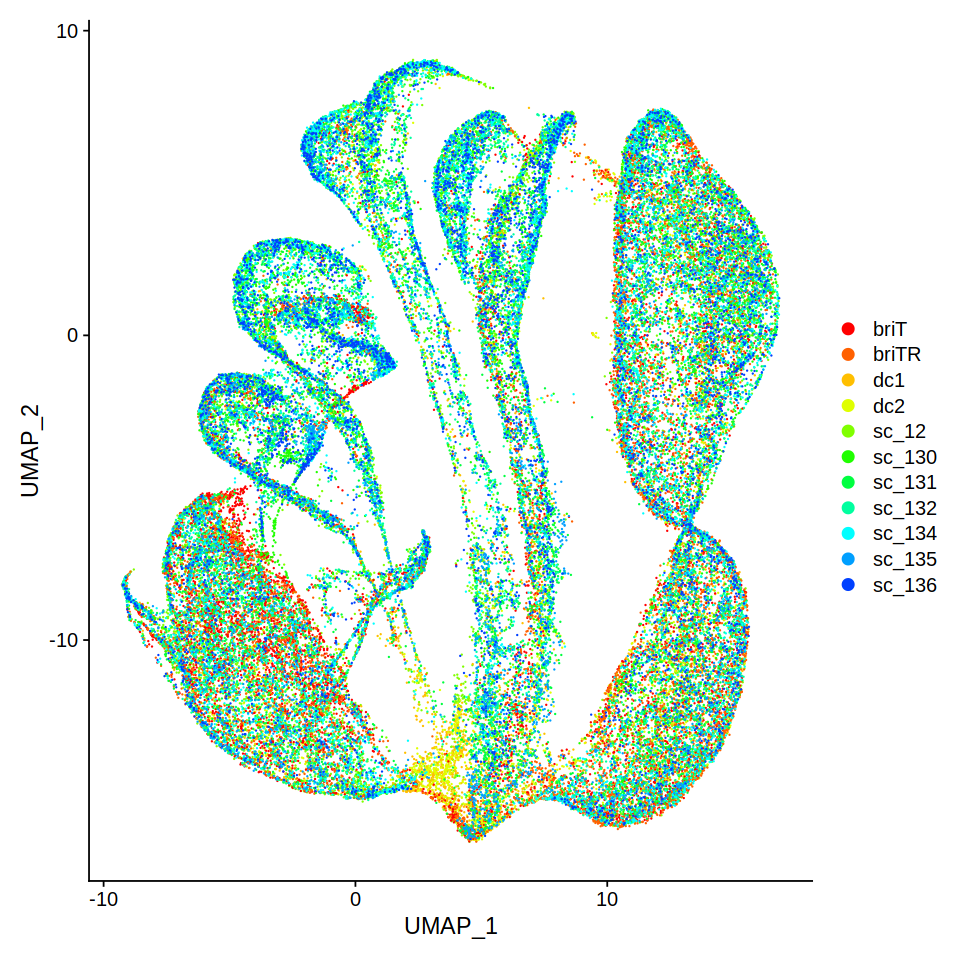

In [43]:
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(rc.integrated, reduction = "umap", group.by = "orig.ident", cols= rainbow(16))

In [44]:
rc.integrated$time.anno.Li.crude <- gsub("_.*$","",rc.integrated$time.celltype.anno.Li.crude)
rc.integrated$celltype.anno.Li.crude <- gsub("Distal Columella","Distal Columella_Columella",rc.integrated$time.celltype.anno.Li.crude)
rc.integrated$celltype.anno.Li.crude <- gsub("Distal Lateral Root Cap","Distal Lateral Root Cap_Lateral Root Cap",rc.integrated$celltype.anno.Li.crude)
rc.integrated$celltype.anno.Li.crude <- gsub("Proximal Columella","Proximal Columella_Columella",rc.integrated$celltype.anno.Li.crude)
rc.integrated$celltype.anno.Li.crude <- gsub("Proximal Lateral Root Cap","Proximal Lateral Root Cap_Lateral Root Cap",rc.integrated$celltype.anno.Li.crude)
rc.integrated$celltype.anno.Li.crude <- gsub("^.*_","",rc.integrated$celltype.anno.Li.crude)

In [45]:
table(rc.integrated$time.anno.Li.crude, rc.integrated$orig.ident)

                           
                            briT briTR  dc1  dc2 sc_12 sc_130 sc_131 sc_132
  Distal Columella           220   409    0    0     0    835    632    443
  Distal Lateral Root Cap    415  1080    0    0     0    699    565    679
  Elongation                2022  1911    0    0     0   2685   2226   2199
  Maturation                1781   896    0    0     0   1205   1431   1515
  Proliferation Domain       604   336    0    0     0     62    864    309
  Proximal Columella         183   228    0    0     0     60     40     31
  Proximal Lateral Root Cap 1953  3068    0    0     0    359   1235    918
  Transition Domain          305   390    0    0     0    684    622    456
                           
                            sc_134 sc_135 sc_136
  Distal Columella             537    268    611
  Distal Lateral Root Cap      971    201    581
  Elongation                  2778   1331   2225
  Maturation                  1669    941   1298
  Proliferation

In [46]:
table(rc.integrated$time.celltype.anno.Li.crude, rc.integrated$orig.ident)

                                       
                                        briT briTR  dc1  dc2 sc_12 sc_130
  Distal Columella                       220   409    0    0     0    835
  Distal Lateral Root Cap                415  1080    0    0     0    699
  Elongation_Atrichoblast                 22   117    0    0     0    763
  Elongation_Cortex                       58   103    0    0     0    824
  Elongation_Endodermis                  272   317    0    0     0    387
  Elongation_Pericycle                   707   689    0    0     0     87
  Elongation_Phloem                       77   175    0    0     0     30
  Elongation_Procambium                  546   283    0    0     0     89
  Elongation_Trichoblast                  66    27    0    0     0    371
  Elongation_Xylem                       274   200    0    0     0    134
  Maturation_Atrichoblast                 19   116    0    0     0    275
  Maturation_Cortex                      171    35    0    0     0    12

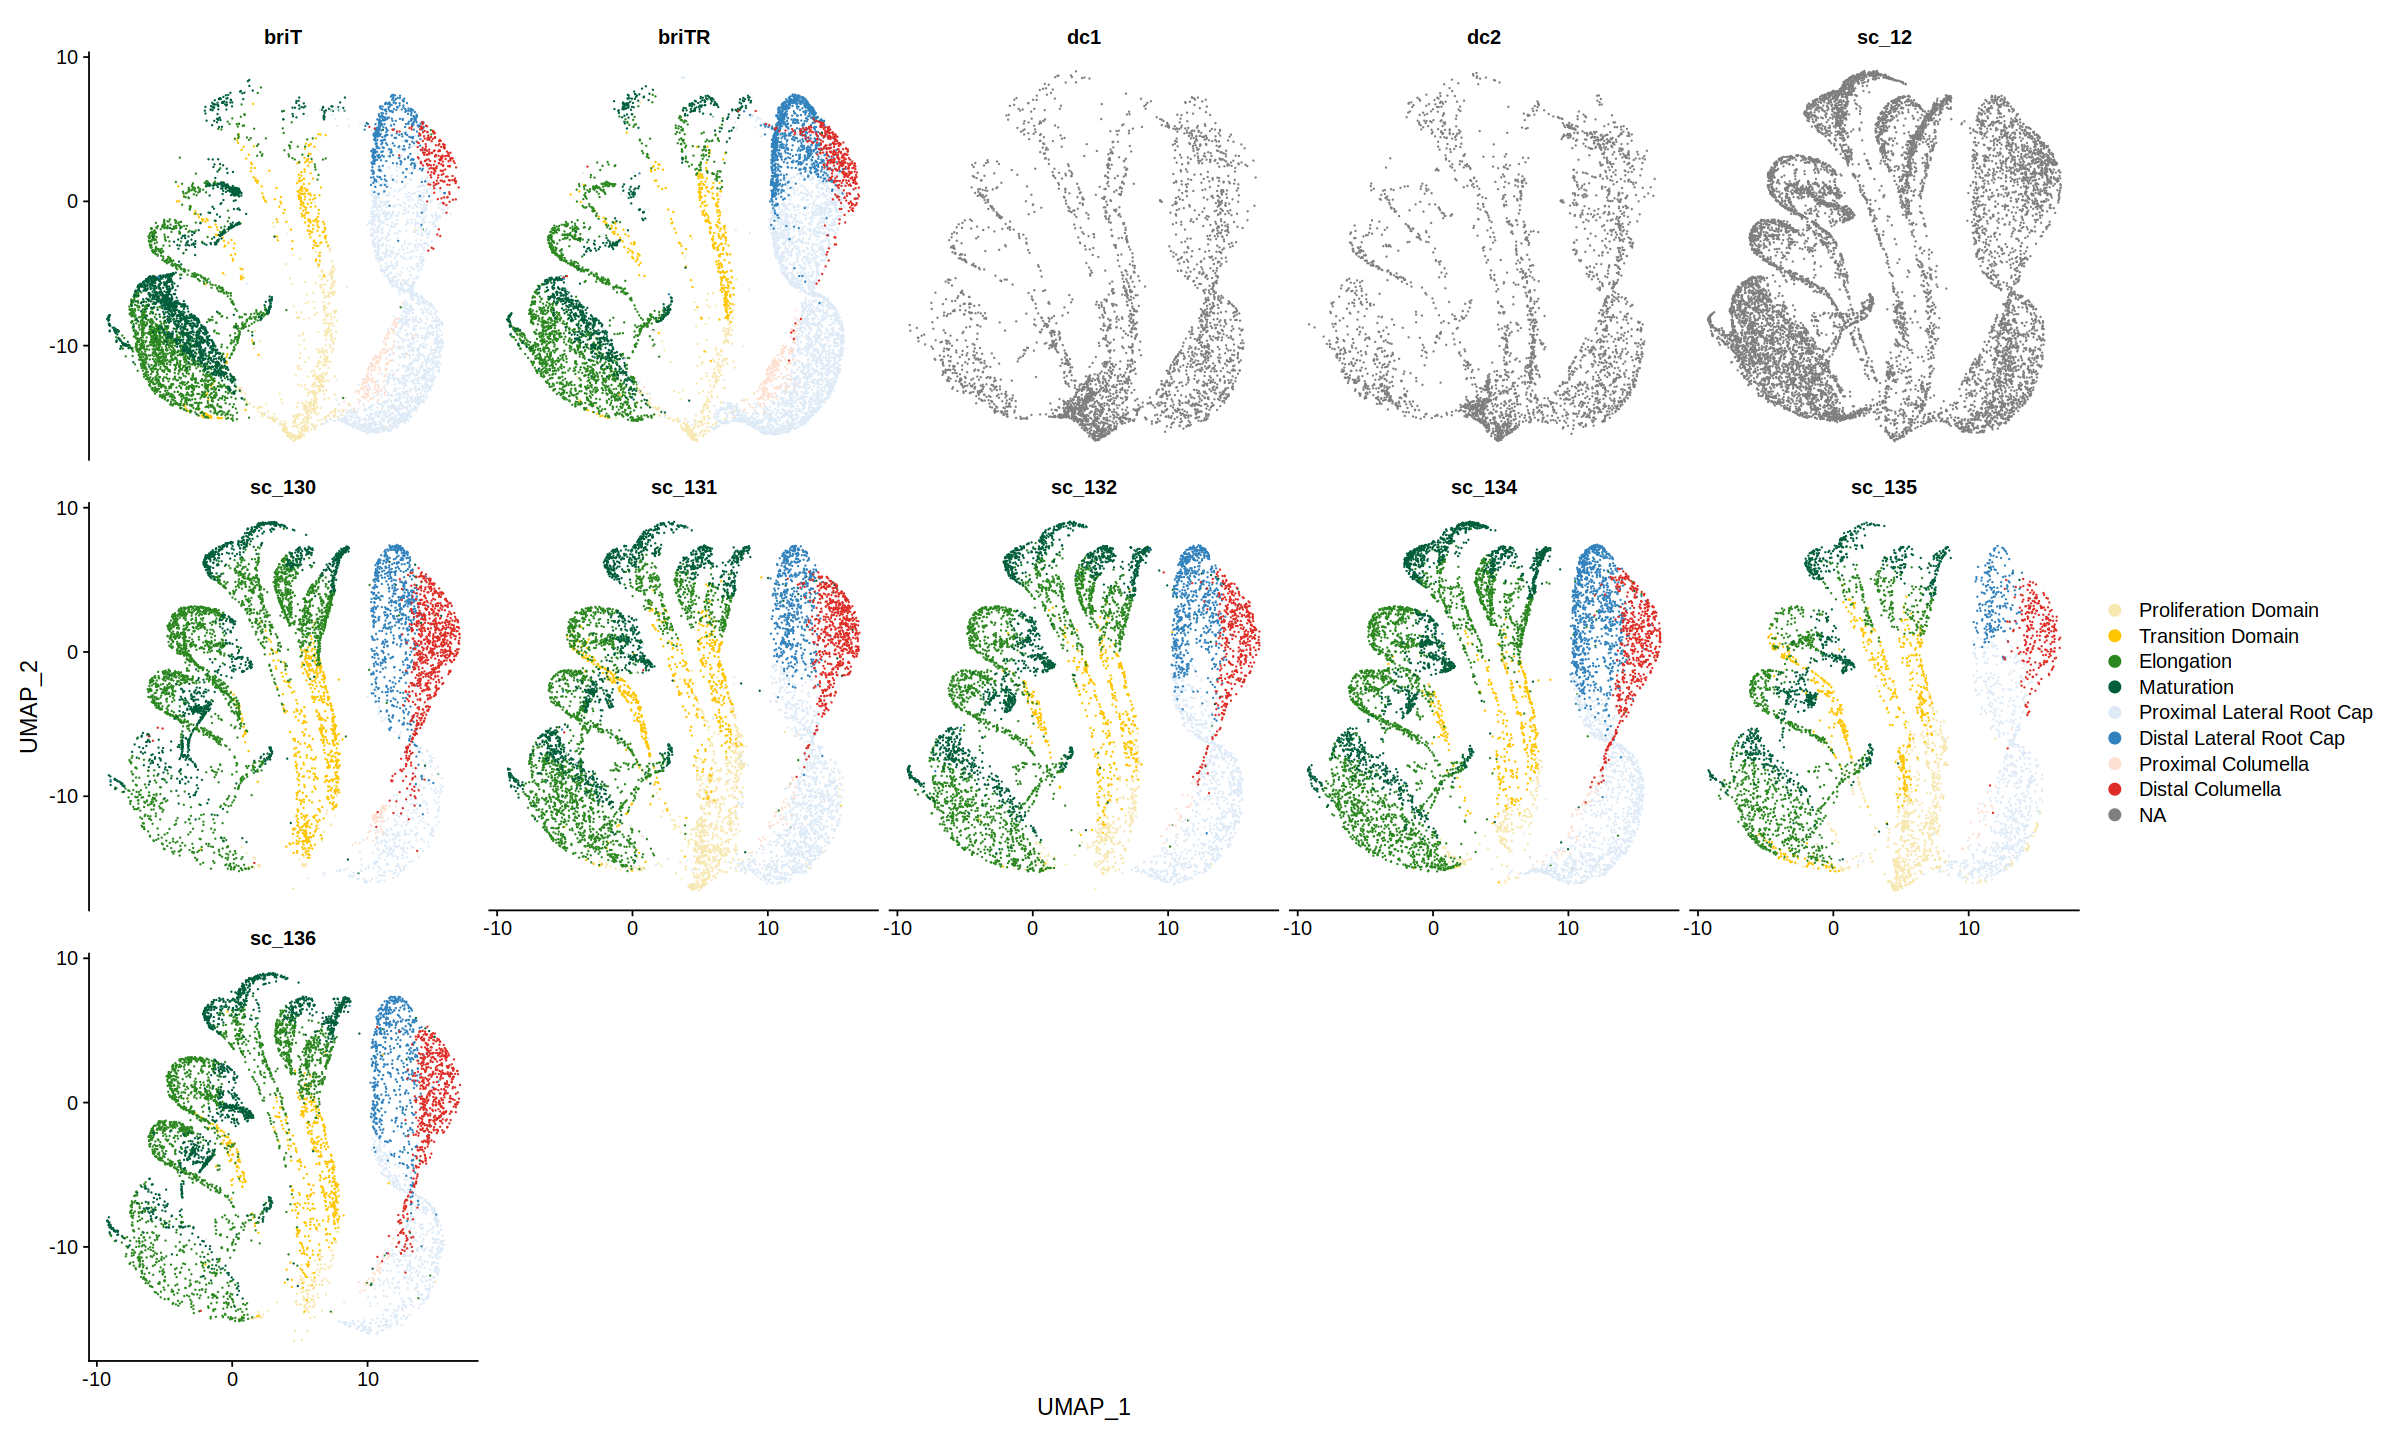

In [47]:
options(repr.plot.width=20, repr.plot.height=12)
DimPlot(rc.integrated, reduction = "umap", group.by = "time.anno.Li.crude", split.by = "orig.ident", ncol = 5, 
       order = c("Distal Columella","Proximal Columella","Distal Lateral Root Cap","Proximal Lateral Root Cap","Maturation","Elongation", "Transition Domain", "Proliferation Domain"), 
        cols = c('#F7E7B0','#FFC400','#2B871F','#005E3B', "#deebf7", "#3182bd", '#fee0d2','#de2d26'))

In [48]:
library(RColorBrewer)
library(grid)
library(gplots)
plot_anno <- function(rc.integrated){
order <- c("Quiescent Center", "Ground Tissue","Columella", "Lateral Root Cap", "Atrichoblast", "Trichoblast", "Cortex", "Endodermis", "Phloem","Protophloem", "Xylem", "Procambium","Pericycle","Phloem Pole Pericycle", "Protoxylem", "Metaxylem", "Unknown")
palette <- c("#9400d3", "#DCD0FF","#5ab953", "#bfef45", "#008080", "#21B6A8", "#82b6ff", "#0000FF","#e6194b", "#dd77ec", "#9a6324", "#ffe119", "#ff9900", "#ffd4e3", "#9a6324", "#ddaa6f", "#EEEEEE")
rc.integrated$celltype.anno.Li.crude <- factor(rc.integrated$celltype.anno.Li.crude, levels = order[sort(match(unique(rc.integrated$celltype.anno.Li.crude),order))]) 
color <- palette[sort(match(unique(rc.integrated$celltype.anno.Li.crude),order))]
p1 <- DimPlot(rc.integrated, reduction = "umap", group.by = "celltype.anno.Li.crude", cols=color)
p2 <- DimPlot(rc.integrated, reduction = "umap", group.by = "time.anno.Li.crude",order = c("Distal Columella","Proximal Columella","Distal Lateral Root Cap","Proximal Lateral Root Cap","Maturation","Elongation", "Transition Domain", "Proliferation Domain"), cols = c('#F7E7B0','#FFC400','#2B871F','#005E3B', "#deebf7", "#3182bd", '#fee0d2','#de2d26'))
p3 <- DimPlot(rc.integrated, reduction = "umap", group.by = "consensus.time.group", cols=brewer.pal(10,"Spectral"))
p4 <- DimPlot(rc.integrated, reduction = "umap", group.by = "branch.anno")
options(repr.plot.width=18, repr.plot.height=12)
gl <- lapply(list(p1, p2, p3, p4), ggplotGrob)
gwidth <- do.call(unit.pmax, lapply(gl, "[[", "widths"))
gl <- lapply(gl, "[[<-", "widths", value = gwidth)
gridExtra::grid.arrange(grobs=gl, ncol=2)
}

# order = c("Distal Columella","Proximal Columella","Distal Lateral Root Cap","Proximal Lateral Root Cap","Maturation","Elongation", "Transition Domain", "Proliferation Domain"), cols = c('#F7E7B0','#FFC400','#2B871F','#005E3B', "#deebf7", "#3182bd", '#fee0d2','#de2d26')

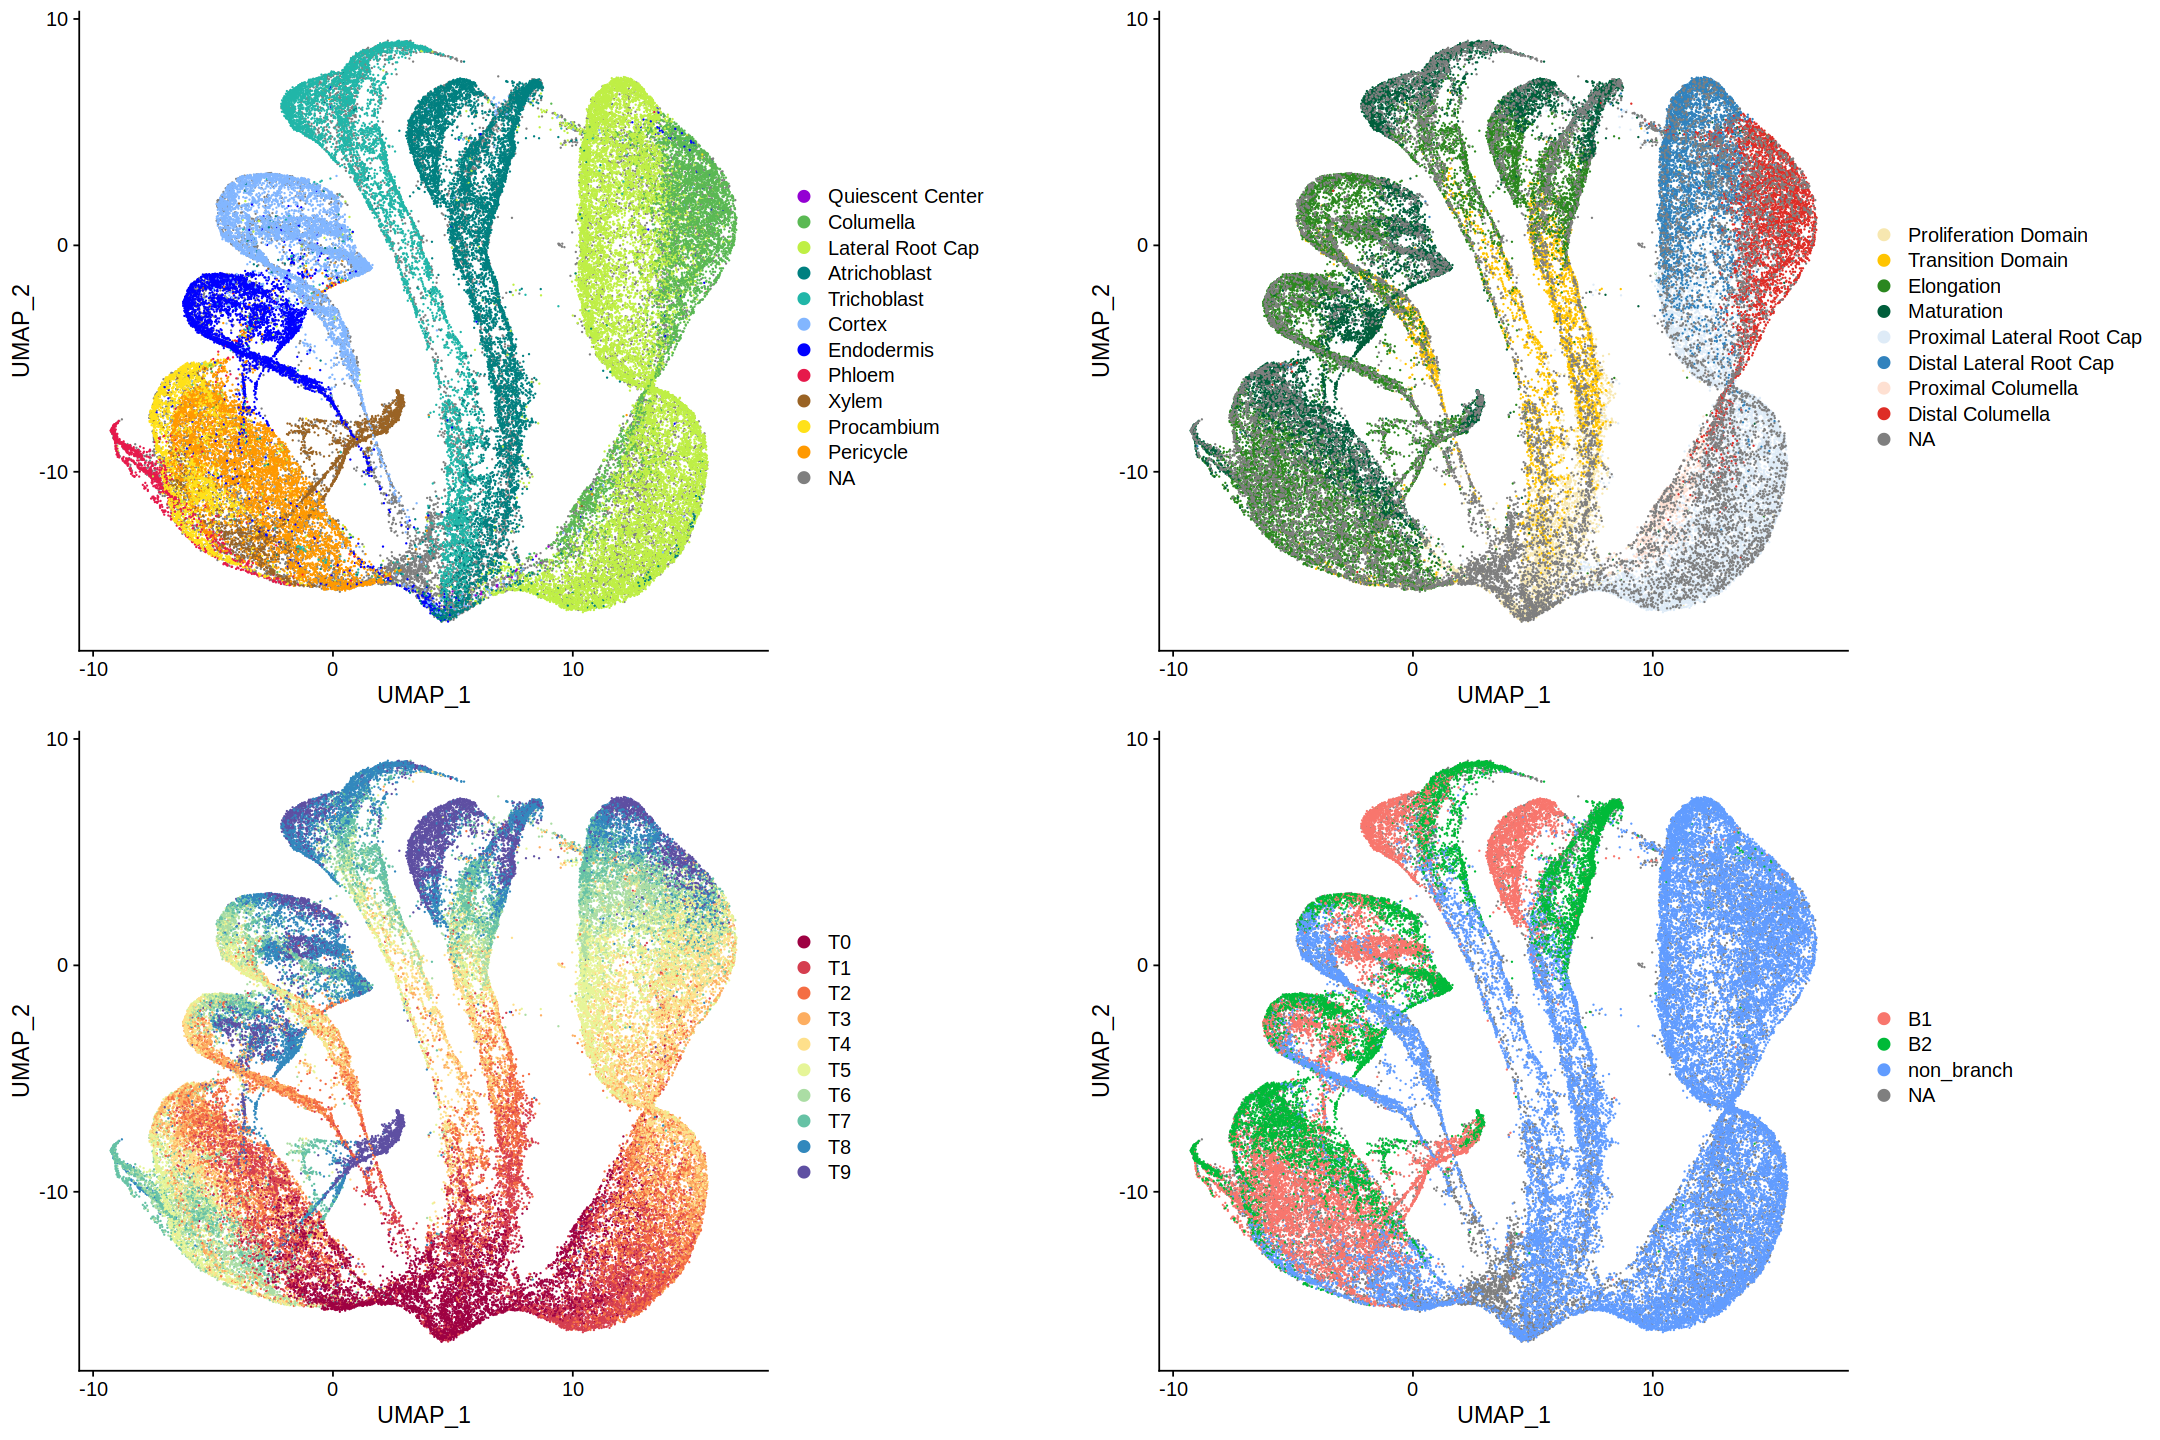

In [49]:
plot_anno(rc.integrated)

In [50]:
saveRDS(rc.integrated, file = "./scRNA-seq/Integrated_Objects/rc.integrated_11S_CVP_BRI1_seu3_20230315.rds")